## Imports

In [1]:
import pandas as pd
import requests
import io
import os
from pathlib import Path

## 1. Data Acquisition

Step 1.1: Define seasons and create data directory

In [2]:
seasons = ["1920", "2021", "2122", "2223", "2324", "2425"]
current_season = "2526" # The season that just started
all_seasons = seasons + [current_season]

# Base URL for the Premier League data
base_url = "https://www.football-data.co.uk/mmz4281/{}/E0.csv"

# Create a directory to store our raw data
# The `pathlib` library is great for handling file paths
raw_data_dir = Path("data/raw")
raw_data_dir.mkdir(parents=True, exist_ok=True)

print(f"Seasons to download: {all_seasons}")
print(f"Data will be saved in: {raw_data_dir}")

Seasons to download: ['1920', '2021', '2122', '2223', '2324', '2425', '2526']
Data will be saved in: data/raw


Step 1.2: Download the data for each season

In [3]:
for season in all_seasons:
    url = base_url.format(season)
    filepath = raw_data_dir / f"E0_{season}.csv"

    if filepath.exists():
        print(f"File for season {season} already exists. Skipping.")
        continue

    try:
        print(f"Downloading data for season {season} from {url}...")
        response = requests.get(url)
        response.raise_for_status()  # This will raise an error for bad responses (4xx or 5xx)
        
        # Write the content to a local file
        with open(filepath, 'wb') as f:
            f.write(response.content)
        print(f"Successfully saved to {filepath}")

    except requests.exceptions.RequestException as e:
        print(f"Could not download data for season {season}. Error: {e}")

print("\nData download process complete.")

File for season 1920 already exists. Skipping.
File for season 2021 already exists. Skipping.
File for season 2122 already exists. Skipping.
File for season 2223 already exists. Skipping.
File for season 2324 already exists. Skipping.
File for season 2425 already exists. Skipping.
File for season 2526 already exists. Skipping.

Data download process complete.


Step 1.4: Load and combine all the downloaded data into a single DataFrame

In [4]:
all_games_df = pd.DataFrame()

for season in all_seasons:
    filepath = raw_data_dir / f"E0_{season}.csv"
    if filepath.exists():
        try:
            season_df = pd.read_csv(filepath, encoding='latin1')
            season_df['Season'] = season
            all_games_df = pd.concat([all_games_df, season_df], ignore_index=True)
        except Exception as e:
            print(f"Could not read file {filepath}. Error: {e}")


# Display the first few rows and the shape of the combined dataframe
print("Combined DataFrame shape:", all_games_df.shape)
all_games_df.head()


Combined DataFrame shape: (2290, 164)


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,BMGMCA,BVCH,BVCD,BVCA,CLCH,CLCD,CLCA,LBCH,LBCD,LBCA
0,E0,09/08/2019,20:00,Liverpool,Norwich,4,1,H,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,10/08/2019,12:30,West Ham,Man City,0,5,A,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,10/08/2019,15:00,Bournemouth,Sheffield United,1,1,D,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,10/08/2019,15:00,Burnley,Southampton,3,0,H,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,10/08/2019,15:00,Crystal Palace,Everton,0,0,D,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Data Processing & Feature Engineering

Step 2.1: Select and rename the essential columns

In [5]:
core_cols = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'Season']
football_data = all_games_df[core_cols].copy()

football_data.rename(columns={
    'Date': 'date',
    'HomeTeam': 'home_team',
    'AwayTeam': 'away_team',
    'FTHG': 'home_goals',
    'FTAG': 'away_goals',
    'Season': 'season'
}, inplace=True)

football_data.head()


,date,home_team,away_team,home_goals,away_goals,season
0,09/08/2019,Liverpool,Norwich,4,1,1920
1,10/08/2019,West Ham,Man City,0,5,1920
2,10/08/2019,Bournemouth,Sheffield United,1,1,1920
3,10/08/2019,Burnley,Southampton,3,0,1920
4,10/08/2019,Crystal Palace,Everton,0,0,1920


Step 2.2: Data Cleaning and Type Conversion

In [6]:
football_data['date'] = pd.to_datetime(football_data['date'], errors='coerce')

football_data.dropna(subset=['date', 'home_team', 'away_team', 'home_goals', 'away_goals'], inplace=True)

# Convert goal columns to integers, as they should be whole numbers.
football_data['home_goals'] = football_data['home_goals'].astype(int)
football_data['away_goals'] = football_data['away_goals'].astype(int)

football_data.sort_values(by='date', inplace=True)

# Reset the index after sorting and dropping rows
football_data.reset_index(drop=True, inplace=True)

print("Data cleaning and type conversion complete.")
print("\nCleaned DataFrame shape:", football_data.shape)
football_data.info()

football_data.tail()

Data cleaning and type conversion complete.

Cleaned DataFrame shape: (878, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        878 non-null    datetime64[ns]
 1   home_team   878 non-null    object        
 2   away_team   878 non-null    object        
 3   home_goals  878 non-null    int64         
 4   away_goals  878 non-null    int64         
 5   season      878 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 41.3+ KB


,date,home_team,away_team,home_goals,away_goals,season
873,2025-12-04,Arsenal,Brentford,1,1,2425
874,2025-12-04,Southampton,Aston Villa,0,3,2425
875,2025-12-04,Nott'm Forest,Everton,0,1,2425
876,2025-12-04,Brighton,Leicester,2,2,2425
877,2025-12-04,Man City,Crystal Palace,5,2,2425


Step 2.3: Filter out teams with insufficient data

In [7]:
MIN_HOME_GAMES = 19 # One full season of home games
MIN_AWAY_GAMES = 19 # One full season of away games

# Count home and away games for each team
home_games = football_data['home_team'].value_counts()
away_games = football_data['away_team'].value_counts()

# Identify teams that are below EITHER threshold
teams_to_remove_home = home_games[home_games < MIN_HOME_GAMES].index
teams_to_remove_away = away_games[away_games < MIN_AWAY_GAMES].index
teams_to_remove = teams_to_remove_home.union(teams_to_remove_away)


if len(teams_to_remove) > 0:
    print(f"Removing teams with fewer than {MIN_HOME_GAMES} home or {MIN_AWAY_GAMES} away games: {list(teams_to_remove)}")
    
    # Filter the main dataframe and reset the index
    football_data_filtered = football_data[
        ~football_data['home_team'].isin(teams_to_remove) &
        ~football_data['away_team'].isin(teams_to_remove)
    ].copy().reset_index(drop=True)

    print(f"Original shape: {football_data.shape}")
    print(f"New filtered shape: {football_data_filtered.shape}")
else:
    print("No teams to remove. All teams meet the minimum game thresholds.")
    football_data_filtered = football_data.copy()

Removing teams with fewer than 19 home or 19 away games: ['Ipswich', 'Luton', 'Norwich', 'Watford', 'West Brom']
Original shape: (878, 6)
New filtered shape: (777, 6)


Step 2.4: Detailed Data Quality Check

In [8]:
final_teams = sorted(football_data_filtered['home_team'].unique())
print(f"Final number of teams for modeling: {len(final_teams)}")

final_home_games = football_data_filtered['home_team'].value_counts()
final_away_games = football_data_filtered['away_team'].value_counts()
final_total_games = final_home_games.add(final_away_games, fill_value=0)

# Create a summary DataFrame
debug_summary = pd.DataFrame({
    'Home Games': final_home_games,
    'Away Games': final_away_games,
    'Total Games': final_total_games
}).sort_values(by='Total Games', ascending=True)

print("\n--- Data Quality Summary for Model Input ---")
print(debug_summary)
print("------------------------------------------")

Final number of teams for modeling: 22

--- Data Quality Summary for Model Input ---
                  Home Games  Away Games  Total Games
Sheffield United          23          17           40
Leeds                     22          20           42
Nott'm Forest             24          23           47
Burnley                   32          21           53
Bournemouth               28          27           55
Fulham                    27          29           56
Brentford                 25          32           57
Southampton               28          36           64
Leicester                 30          39           69
Crystal Palace            39          36           75
Brighton                  38          38           76
Newcastle                 38          42           80
West Ham                  43          37           80
Arsenal                   36          45           81
Liverpool                 43          39           82
Tottenham                 45          37           

## 3. Modeling with Dixon-Coles

Step 3.1: Import the model and prepare the data

In [9]:
from penaltyblog.models import DixonColesGoalModel, dixon_coles_weights

# We'll use a time decay factor. A common value is around 0.0018,
# which gives a half-life of about one year. This means a game from
# a year ago has half the weight of a game played today.
epsilon = 0.0018

# Generate the time-decay weights using the helper function on the FILTERED data
weights = dixon_coles_weights(
    football_data_filtered["date"], 
    epsilon
)

Step 3.2: Instantiate and train the model

In [10]:
try:
    dixon_coles_model = DixonColesGoalModel(
        football_data_filtered["home_goals"],
        football_data_filtered["away_goals"],
        football_data_filtered["home_team"],
        football_data_filtered["away_team"],
        weights=weights
    )

    print("--- PRE-TRAINING DEBUGGING INFO ---")
    print(f"Teams being trained on ({len(dixon_coles_model.teams)}): {dixon_coles_model.teams}")
    print(f"Number of matches: {len(football_data_filtered)}")
    print(f"Number of weights: {len(weights)}")
    print(f"Initial parameters shape: {dixon_coles_model._params.shape}")
    print("-----------------------------------")

    print("\nTraining the Dixon-Coles model...")
    solver_options = {"method": "Powell"}
    dixon_coles_model.fit(minimizer_options=solver_options)
    print("Model training complete.")

except ValueError as e:
    print("\n--- MODEL TRAINING FAILED ---")
    print(f"Caught a ValueError: {e}")
    print("\nThe debugging information above shows the exact data and parameters used.")
    print("Review the 'Data Quality Summary' in Step 2.4. If any team has a very low or imbalanced number of games, they might be the cause.")
    print("-----------------------------")

--- PRE-TRAINING DEBUGGING INFO ---
Teams being trained on (22): ['Arsenal' 'Aston Villa' 'Bournemouth' 'Brentford' 'Brighton' 'Burnley'
 'Chelsea' 'Crystal Palace' 'Everton' 'Fulham' 'Leeds' 'Leicester'
 'Liverpool' 'Man City' 'Man United' 'Newcastle' "Nott'm Forest"
 'Sheffield United' 'Southampton' 'Tottenham' 'West Ham' 'Wolves']
Number of matches: 777
Number of weights: 777
Initial parameters shape: (46,)
-----------------------------------

Training the Dixon-Coles model...
Model training complete.


Step 3.3: Inspect the model parameters

In [11]:
if 'dixon_coles_model' in locals() and dixon_coles_model._res.success:
    n_teams = len(dixon_coles_model.teams)
    params = dixon_coles_model._params
    
    attack_ratings = pd.Series(params[:n_teams], index=dixon_coles_model.teams, name="Attack")
    defence_ratings = pd.Series(params[n_teams:n_teams*2], index=dixon_coles_model.teams, name="Defence")
    home_advantage = params[n_teams*2]

    print(f"\nHome Advantage: {home_advantage:.3f}\n")

    ratings_df = pd.DataFrame({
        'Attack': attack_ratings,
        'Defence': defence_ratings
    }).sort_values(by='Attack', ascending=False)

    print("Team Ratings:")
    print(ratings_df)
else:
    print("\nModel not trained successfully. Cannot display parameters.")


Home Advantage: 0.223

Team Ratings:
                    Attack   Defence
Man City          1.456473 -1.066170
Liverpool         1.396911 -0.876492
Arsenal           1.360198 -1.280639
Chelsea           1.261200 -0.999642
Newcastle         1.259078 -0.995571
Tottenham         1.246017 -0.722864
Brentford         1.199109 -0.807597
Fulham            1.118520 -0.743281
Nott'm Forest     1.036226 -0.807472
Crystal Palace    1.019049 -0.762092
Brighton          1.008306 -0.729369
Man United        0.977087 -0.791281
Aston Villa       0.970649 -0.933783
Leicester         0.950925 -0.597197
Bournemouth       0.911035 -0.842834
Everton           0.903310 -1.052807
Leeds             0.901577 -0.390467
West Ham          0.762226 -0.633343
Wolves            0.731343 -0.616766
Burnley           0.660467 -0.481786
Sheffield United  0.577854 -0.354630
Southampton       0.292439 -0.442732


## 4. Prediction & Visualization

Step 4.1: Make a prediction for a specific match

In [12]:
home_team = "Man City"
away_team = "Liverpool"

prediction = dixon_coles_model.predict(home_team, away_team)

print(f"Prediction for {home_team} vs {away_team}:\n")
print(f"Home Win: {prediction.home_win:.2%}")
print(f"Draw:       {prediction.draw:.2%}")
print(f"Away Win: {prediction.away_win:.2%}")

Prediction for Man City vs Liverpool:

Home Win: 56.70%
Draw:       19.72%
Away Win: 23.59%


In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Step 4.2: Visualize the Correct Score probabilities

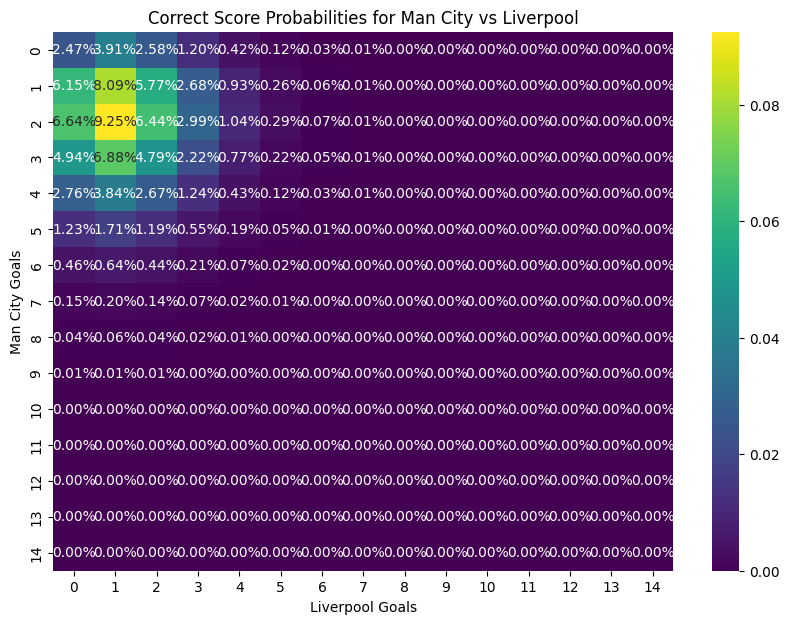

In [16]:
# Use the goal_matrix attribute instead of to_df()
score_matrix = prediction.goal_matrix

# If you need it as a DataFrame, convert it
import pandas as pd
score_matrix_df = pd.DataFrame(score_matrix)

# Create the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(score_matrix_df, annot=True, fmt=".2%", cmap="viridis")
plt.xlabel(f"{away_team} Goals")
plt.ylabel(f"{home_team} Goals")
plt.title(f"Correct Score Probabilities for {home_team} vs {away_team}")
plt.show()